In [45]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os 
from sklearn.model_selection import train_test_split

## Creating the required datasets and cleaning

In [46]:
years = [str(i) for i in range(2010,2018)]
def createData():
    indicatorList = pd.read_csv('Indicator.csv')

    indicatorsToPick = indicatorList[indicatorList['included']==1]
    gdp_percap = indicatorsToPick[indicatorsToPick['feature_name']=='gdp_percap']
    indicatorsToPick = indicatorsToPick.drop(index=2) # GDP is Index 2

    def getDF(code):
        path = os.getcwd() + "\Datasets\\"
        newPath = path + code
        df = pd.read_csv(newPath + "\\" + os.listdir(newPath)[0])
        return df

    indicators = list(indicatorsToPick.Indicator_Code)
    features = []
    target = getDF("NY.GDP.PCAP.KD.ZG")

    for i in indicators:
        features.append(getDF(i))

    attributes = list(indicatorsToPick.feature_name)

    Developed = set(["Andorra","Austria","Belgium","Cyprus","Czech Republic","Denmark","Estonia","Faroe Islands","Finland","France","Germany","Greece","Guernsey","Holy See","Iceland","Ireland","Italy","Jersey","Latvia","Liechtenstein","Lithuania","Luxembourg","Malta","Monaco","Netherlands","Norway","Portugal","San Marino","Slovakia","Slovenia","Spain","Sweden","Switzerland","United Kingdom","Hong Kong","Israel","Japan","Macau","Singapore","South Korea","Taiwan","Bermuda","Canada","Puerto Rico","United States","Australia","New Zealand"])

    Developing = set(features[0]['Country Name'])
    Developing -= Developed

    dev = [None]*(len(features)+1)
    dev1 = [None]*(len(features)+1)
    n = len(features)

    for i in range(n):
        dev[i] = features[i][features[i]['Country Name'].isin(Developed)]
        dev1[i] = features[i][features[i]['Country Name'].isin(Developing)]

    # i+=1
    dev[n] = target[target['Country Name'].isin(Developed)]
    dev1[n] = target[target['Country Name'].isin(Developing)]

    def createDataset(year,dfList):
        factors = [dfList[0]["Country Name"]]
        for x in dfList:
            factors.append(x[year])
        df = pd.concat(factors,axis =1, sort = False)
        # print(df.head)
        df.columns = ['country'] + attributes + ['gdp_percap']
        total_rows = max(df.count())
        
        return df

    developed = [createDataset(i,dev) for i in years]
    developing = [createDataset(i,dev1) for i in years]

    return (developed, developing)

developed,developing = createData()

#  Cleaning the Data 

# - Removing all rows with missing values for GDP
# - Median replacement for all other parameters

def cleanData(df):
    ### 1. Removing all rows that have NaNs/missing values in the target attribute
    for i in range(len(years)):
        df[i] = df[i].dropna(subset=["gdp_percap"])

    ### 2. Median replacement of missing values for the other features
    for i in range(len(years)):
            #print("\n\n\n",years[i])
            for j in df[i].iloc[:,1:]:
                df[i][j] = df[i][j].fillna(np.nanmedian(df[i][j]))

cleanData(developed)
cleanData(developing)

In [47]:
def checkLinearRelationship(df):
    for j in df.iloc[:,1:-1]:
        plt.title("GDP vs "+j)
        plt.scatter(df[j],df.gdp_percap)
        plt.show()

In [48]:
def createSplitsDeveloped(index, dev):
    if dev==0: # implying developed
        devyear = developed[index]
    elif dev==1: 
        devyear = developing[index] 
    gdpyeardev = devyear[['gdp_percap']]
    devyear = devyear.drop(columns=['country','gdp_percap'])

    X_train, X_test, y_train, y_test = train_test_split(devyear,gdpyeardev,test_size=0.15, random_state=0)
    return (X_train, X_test, y_train, y_test)

## Lasso Regression for Feature Selection

In [49]:
from sklearn.linear_model import Lasso, LassoCV

indicatorList = pd.read_csv('Indicator.csv')
indicatorsToPick = indicatorList[indicatorList['included']==1].drop(index=2)
attributes = list(indicatorsToPick.feature_name)

model = Lasso(alpha=0.75)
splits2010 = createSplitsDeveloped(0,0) # For Developed countries for the year 2010 
# print(splits2010[0])

model.fit(splits2010[0], splits2010[2])

attCoef = {}

for i in range(len(attributes)):
    attCoef[attributes[i]] = model.coef_[i]

# print(mod)
print(attCoef)

{'pop_grow': 0.0, 'gini_index': -0.0, 'unemp': -0.14712717411066126, 'life_exp': 0.0, 'poverty': -0.0, 'mil_xpnd': 0.21288755932488881, 'lit_rate': 0.0, 'labour_force': -9.013417546509046e-10, 'refugee_asylum': 3.7845592916933612e-06}


## Sparse PCA for Developed and Developing 

Done to check what are the important features for each to try and bring about a comparison

In [24]:
X_dev = developed[0].drop(columns=['country','gdp_percap'])
X_deving = developing[0].drop(columns=['country','gdp_percap'])

X_dev.shape

(37, 9)

In [16]:
from sklearn.decomposition import SparsePCA

PCA = SparsePCA(n_components=5, random_state=0)
dev2010New = PCA.fit_transform(X_dev)
paramdev2010 = PCA.get_params(deep=True)

In [17]:
paramdev2010

{'U_init': None,
 'V_init': None,
 'alpha': 1,
 'max_iter': 1000,
 'method': 'lars',
 'n_components': 5,
 'n_jobs': None,
 'normalize_components': 'deprecated',
 'random_state': 0,
 'ridge_alpha': 0.01,
 'tol': 1e-08,
 'verbose': False}

## Trying Polynomial Regression

In [30]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True)
newXdeving = poly.fit_transform(X_deving)
Y = developing[0][['gdp_percap']]

print(newXdeving.shape)
print(Y.shape)

(213, 46)
(213, 1)


In [34]:
import statsmodels.api as sm 

newXdev = sm.add_constant(newXdev) # adding a constant
Y = developed[0][['gdp_percap']]

model = sm.OLS(Y, newXdev).fit()
predictions = model.predict(newXdev) 
 
summary = str(model.summary())
print(summary)

                            OLS Regression Results                            
Dep. Variable:             gdp_percap   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     1.495
Date:                Fri, 06 Nov 2020   Prob (F-statistic):              0.382
Time:                        23:11:37   Log-Likelihood:                -47.133
No. Observations:                  37   AIC:                             160.3
Df Residuals:                       4   BIC:                             213.4
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5941      0.998     -0.595      0.5

## Trying SVM because nothing else seems to be working ffs

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR

dev2010 = developed[0]
gdp2010dev = dev2010[['gdp_percap']]
dev2010 = dev2010.drop(columns=['country','gdp_percap'])

X_train, X_test, y_train, y_test = train_test_split(dev2010,gdp2010dev,test_size=0.15, random_state=0)

In [40]:
linSVR = LinearSVR()   
linSVR.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=None, tol=0.0001, verbose=0)

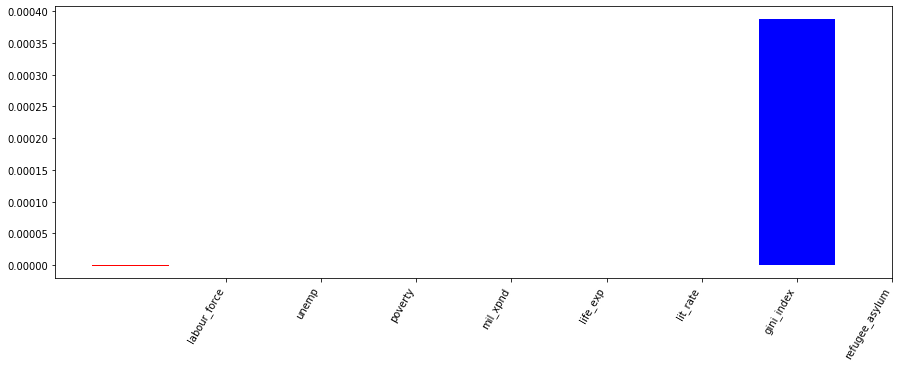

In [50]:
def plot_coefficients(model, feature_names, top_features=4):
 coef = model.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
#  plt.xlim(-1,1)
 plt.show()

plot_coefficients(linSVR, attributes)

In [53]:
weights = list(linSVR.coef_.ravel())
weights

[1.1969621591070794e-07,
 4.379676967886106e-07,
 -1.1750078918834596e-07,
 2.2171958712923874e-07,
 2.844375648216469e-09,
 6.50605582085156e-08,
 3.8049721222859444e-07,
 -1.0019992168281784e-06,
 0.00038853358330293264]

In [54]:
# linSVR.predict(X_test)
linSVR.score(X_test,y_test) # lmao this is so bad

-4.507110607725664